In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sweep
import tools
from matplotlib.ticker import FuncFormatter
from matplotlib.widgets import Slider, Button
import copy

In [2]:
%matplotlib qt

In [3]:
class K(tools.K):
    # INITIATION
    l = 1e9 * 0.00001  # 8 10
    l_ = 1e5  # 5 6

    qE = 1e9  # 8 10
    qE_ = 1e8  # 7 9
    H = 1e9  # 8 10

    qH = 1e6  # 2000
    redQ = 1e9
    oxQ = 1

    qQD = 2

    qPh = 1e-5

    D = 1
    D_ = 0.05

    r = 1e9
    p = 0.0001

    rD = 1e9

    # POLYMERIZATION
    # pI = 0
    # pP = 0
    # pDD = 0
    # pDrP = 0
    # pDdP = 0

class K2(tools.K):
    # INITIATION
    l = 1e9 * 0.00001  # 8 10
    l_ = 1e6  # 5 6

    qE = 1e10  # 8 10
    qE_ = 1e7  # 7 9
    H = 1e9  # 8 10

    qH = 1e5  # 2000
    redQ = 1e9
    oxQ = 1

    qQD = 2

    qPh = 1e-5

    D = 1
    D_ = 0.05

    r = 1e9
    p = 0.0001

    rD = 1e8


class K_sweep(tools.K):
    # INITIATION

    l = 1e9 * 0.00001  # 8 10
    l_ = 1e5  # 5 6

    qE = 1e9  # 8 10
    qE_ = 1e8  # 7 9
    H = 1e9  # 8 10

    qH = 1e6  # 2000
    redQ = 1e9

    r = 1e9

    rD = 1e9

In [4]:
T = np.linspace(0, 0.001, 100)

In [5]:
def system_full(t, C, k=K()):
    [Q, Qt, DH, Q_DH, QH, D, QHH, QHD, QD] = C
    C1 = Q
    C2 = Qt
    C3 = DH
    C4 = Q_DH
    C5 = QH
    C6 = D
    C7 = QHH
    C8 = QHD
    C9 = QD

    R1 = k.l * C1
    R2 = k.l_ * C2
    R3 = k.qE * C2 * C3
    R4 = k.qE_ * C4
    R5 = k.H * C4
    R6 = k.qH * C2 * C7
    R7 = k.redQ * C5 * C5
    R8 = k.oxQ * C1 * C7
    R9 = k.qQD * C2 * C8
    R10 = k.qPh * C2
    R11 = k.D * C1 * C6
    R12 = k.D_ * C9
    R13 = k.r * C5 * C6
    R14 = k.p * C8
    R15 = k.rD * C6 * C6

    res = dict(
        dCl=-R1 + R2 + R7 - R8 - R11 + R12,
        dC2=R1 - R2 - R3 + R4 - R6 - R9 - R10,
        dC3=-R3 + R4,
        dC4=R3 - R4 - R5,
        dC5=R5 + 2 * R6 - 2 * R7 + 2 * R8 + R9 - R13,
        dC6=R5 - R11 + R12 - R13 - 2 * R15,
        dC7=-R6 + R7 - R8 + R14,
        dC8=-R9 + R13 - R14,
        dC9=R9 + R11 - R12,
    )

    return list(res.values())


c_full = '[Q, Qt, DH, Q_DH, QH, D, QHH, QHD, QD]'
initial_full = [1, 0, 1, 0, 0, 0, 0, 0, 0]
init_full=tools.get_init(c_full,initial_full)

In [6]:
def system_base(t, C, k=K()):
    [Q, Qt, DH, QH, D, QHH] = C

    R1 = k.l * Q
    R2 = k.l_ * Qt
    R3 = k.H * Qt * DH
    R6 = k.qH * Qt * QHH
    R7 = k.redQ * QH * QH
    R13 = k.r * QH * D
    R15 = k.rD * D * D

    res = dict(
        Q=-R1 + R2 + R7,
        Qt=R1 - R2 - R3 - R6,
        DH=-R3,
        QH=R3 + 2 * R6 - 2 * R7 - R13,
        D=R3 - R13 - 2 * R15,
        QHH=-R6 + R7,
    )

    return list(res.values())


c_base = '[Q, Qt, DH, QH, D, QHH]'
initial_base = [1, 0, 1, 0, 0, 0]
init_base=tools.get_init(c_base,initial_base)

In [7]:
def pol_base(t, C, k=K()):
    [Q, Qt, DH, QH, D, QHH, M, DM, P] = C

    R1 = k.l * Q
    R2 = k.l_ * Qt
    R3 = k.H * Qt * DH
    R4 = k.qH * Qt * QHH
    R5 = k.redQ * QH * QH
    R6 = k.r * QH * D
    R7 = k.rD * D * D
    R8 = k.pI * D * M
    R9 = k.pP * DM * M
    R10 = k.pP * P * M
    R11 = k.pDD * P * D
    R12 = k.pDrP * P * P
    R13 = k.pDdP * P * P

    res = dict(
        Q=-R1 + R2 + R5,
        Qt=R1 - R2 - R3 - R4,
        DH=-R3,
        QH=R3 + 2 * R4 - 2 * R5 - R6,
        D=R3 - R6 - 2 * R7 - R8 - R11,
        QHH=-R4 + R5,
        M=-R8 - R9 - R10,
        DM=R8 - R9,
        P=R9 - R11 - 2 * R12 - 2 * R13,
    )
    return list(res.values())


c_pol = '[Q, Qt, DH, QH, D, QHH, M, DM, P]'
initial_pol = [1, 0, 1, 0, 0, 0, 0, 0, 0]

#   Plot

In [8]:
class K(tools.K):
    # INITIATION
    l = 1e9 * 0.00001  # 8 10
    l_ = 1e5  # 5 6

    qE = 1e9  # 8 10
    qE_ = 1e8  # 7 9
    H = 1e9  # 8 10

    qH = 1e6  # 2000
    redQ = 1e9
    oxQ = 1

    qQD = 2

    qPh = 1e-5

    D = 1
    D_ = 0.05

    r = 1e9
    p = 0.0001

    rD = 1e9

In [9]:
class K2(tools.K):
    # INITIATION
    l = 1e9 * 1e-5  # 8 10
    l_ = 1e6  # 5 6

    qE = 1e10  # 8 10
    qE_ = 1e7  # 7 9
    H = 1e9  # 8 10

    qH = 1e5  # 2000
    redQ = 1e9
    oxQ = 1

    qQD = 2

    qPh = 1e-5

    D = 1
    D_ = 0.05

    r = 1e9
    p = 0.0001

    rD = 1e8

In [10]:
Y = tools.Solver(system_full, K2(), init_full,  T)

LIM = None
AUTO = True
compounds = dict(
    Q=0,
    DH=0,
    QHH=0,
    QH=2,
    # M=0,
    D=1,
    Qt=2,
)

In [14]:
# Plots

fig, ax = plt.subplots()
gs = plt.GridSpec(2, 2, figure=fig)
fig.subplots_adjust(left=0.25, right=0.99, bottom=0.05, top=0.99, hspace=0.1, wspace=0.1)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
scal = FuncFormatter(lambda x, pos: f'{x*1000: .2f}')

K_base = Y.K


def get_ax(gs, keys_num):
    ax = plt.subplot(gs)
    for c in [key for key, value in compounds.items() if value == keys_num]:
        plots[c] = ax.plot(Y.T, Y[c], label=c)[0]
    ax.legend()
    ax.xaxis.set_major_formatter(scal)
    if LIM is not None:
        ax.set_ylim([-LIM, LIM])
    return ax


# Plots
plots = {}
ax0 = get_ax(gs=gs[0, 0:2], keys_num=0)
ax1 = get_ax(gs=gs[1, 0], keys_num=1)
ax2 = get_ax(gs=gs[1, 1], keys_num=2)

# Sliders
sliders = {}
buttons = {}
K_new = copy.deepcopy(K_base)


def resolve(event=None):
    Y.solve(K=K_new)
    for c, plot in plots.items():
        plot.set_ydata(Y[c])
    fig.canvas.draw_idle()


def get_slider_action(k):
    def update(val):
        K_new[k] = K_base[k] * 10**val
        buttons[k].label.set_text(f"{K_new[k]: .1e}")
        if AUTO:
            resolve()

    return update


def get_zero_button_action(k):
    def update(event):
        K_new[k] = 0
        buttons[k].label.set_text(f"{K_new[k]: .1e}")
        fig.canvas.draw_idle()
        if AUTO:
            resolve()

    return update


def reset(event):
    global K_new
    K_new = copy.deepcopy(K_base)
    for k in sliders:
        sliders[k].reset()
        buttons[k].label.set_text(f"{K_new[k]: .1e}")
    fig.canvas.draw_idle()
    if AUTO:
        resolve()


solve_axes = fig.add_axes([0.02, 0.05, 0.05, 0.05])
solve_button = Button(solve_axes, 'Solve', hovercolor='0.975')
solve_button.on_clicked(resolve)

reset_axes = fig.add_axes([0.08, 0.05, 0.05, 0.05])
reset_button = Button(reset_axes, 'Reset', hovercolor='0.975')
reset_button.on_clicked(reset)

for i, k in enumerate(K_base):
    k_axes = fig.add_axes(
        [
            0.03,  # left
            0.95 - 0.04 * i,  # bottom
            0.10,  # width
            0.03,  # height
        ]
    )
    amp_slider = Slider(
        ax=k_axes,
        label=k,
        valmin=-3,
        valmax=3,
        valinit=0,
        valstep=0.1,
        orientation="horizontal",
    )
    sliders[k] = amp_slider
    amp_slider.on_changed(get_slider_action(k))

    k_zero_axes = fig.add_axes(
        [
            0.15,  # left
            0.955 - 0.04 * i,  # bottom
            0.05,  # width
            0.02,  # height
        ]
    )
    zero_button = Button(k_zero_axes, f"{K_new[k]: .1e}", hovercolor='0.975')
    buttons[k] = zero_button
    zero_button.on_clicked(get_zero_button_action(k))

C:\Users\HOME\AppData\Local\Temp\ipykernel_10252\1577274246.py:25: RuntimeWarning: overflow encountered in scalar multiply
  R13 = k.r * C5 * C6
C:\Users\HOME\AppData\Local\Temp\ipykernel_10252\1577274246.py:34: RuntimeWarning: invalid value encountered in scalar add
  dC5=R5 + 2 * R6 - 2 * R7 + 2 * R8 + R9 - R13,
C:\Users\HOME\AppData\Local\Temp\ipykernel_10252\1577274246.py:35: RuntimeWarning: invalid value encountered in scalar subtract
  dC6=R5 - R11 + R12 - R13 - 2 * R15,
C:\Users\HOME\AppData\Local\Temp\ipykernel_10252\1577274246.py:37: RuntimeWarning: invalid value encountered in scalar add
  dC8=-R9 + R13 - R14,
C:\Users\HOME\AppData\Local\Temp\ipykernel_10252\1577274246.py:38: RuntimeWarning: invalid value encountered in scalar add
  dC9=R9 + R11 - R12,
d:\WORKS\Diplom-work\zVid_env\lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
Traceback (most re

# Sweep

In [8]:
y1= tools.Solver(system_full, K(), init_full,  T)
y2 = tools.Solver(system_base, K_sweep(), init_base, T)

KeyboardInterrupt: 

In [ ]:
y2.initial

{'Q': 1, 'Qt': 0, 'DH': 1, 'QH': 0, 'D': 0, 'QHH': 0}

In [ ]:
sweep.sweep(
    y1,y2
)

100%|██████████| 19683/19683 [14:32<00:00, 22.57it/s]


# results

In [17]:
res= pd.read_csv('result_K.csv',index_col=0)
res

,Q,QHH,DH,D,l,l_,qE,qE_,H,qH,redQ,r,rD
0,0.082054,40.074876,0.121908,0.164130,1000.0,10000.0,1.000000e+08,1.000000e+07,1.000000e+08,100000.0,1.000000e+08,1.000000e+08,1.000000e+08
1,0.030037,20.790458,0.050531,0.020474,1000.0,10000.0,1.000000e+08,1.000000e+07,1.000000e+08,100000.0,1.000000e+08,1.000000e+08,1.000000e+09
2,0.010977,8.583295,0.019391,0.003883,1000.0,10000.0,1.000000e+08,1.000000e+07,1.000000e+08,100000.0,1.000000e+08,1.000000e+08,1.000000e+10
3,0.104643,10.132410,0.114915,0.059329,1000.0,10000.0,1.000000e+08,1.000000e+07,1.000000e+08,100000.0,1.000000e+08,1.000000e+09,1.000000e+08
4,0.030886,5.717358,0.036464,0.017724,1000.0,10000.0,1.000000e+08,1.000000e+07,1.000000e+08,100000.0,1.000000e+08,1.000000e+09,1.000000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19678,0.014809,11.848840,0.026761,0.060934,100000.0,1000000.0,1.000000e+10,1.000000e+09,1.000000e+10,10000000.0,1.000000e+10,1.000000e+09,1.000000e+09
19679,0.007318,7.937548,0.015773,0.011250,100000.0,1000000.0,1.000000e+10,1.000000e+09,1.000000e+10,10000000.0,1.000000e+10,1.000000e+09,1.000000e+10
19680,0.007136,2.432243,0.008568,0.171982,100000.0,1000000.0,1.000000e+10,1.000000e+09,1.000000e+10,10000000.0,1.000000e+10,1.000000e+10,1.000000e+08
19681,0.016526,8.227681,0.026144,0.268342,100000.0,1000000.0,1.000000e+10,1.000000e+09,1.000000e+10,10000000.0,1.000000e+10,1.000000e+10,1.000000e+09


In [18]:
a= res['Q']
plt.scatter( a[a>a.median()*100].index, a[a>a.median()*100])

In [19]:
errors= res.iloc[a[a>a.median()*1e5].index]

In [20]:
errors[errors['Q']==errors['Q'].max()].apply(np.log10)

,Q,QHH,DH,D,l,l_,qE,qE_,H,qH,redQ,r,rD
12486,83.1727,86.173134,61.542629,80.683827,4.0,6.0,10.0,7.0,9.0,5.0,9.0,9.0,8.0


In [11]:
ks ='[l, l_, qE, qE_, H, qH, redQ, r, rD]'[1:-1].split(', ')
ks

['l', 'l_', 'qE', 'qE_', 'H', 'qH', 'redQ', 'r', 'rD']

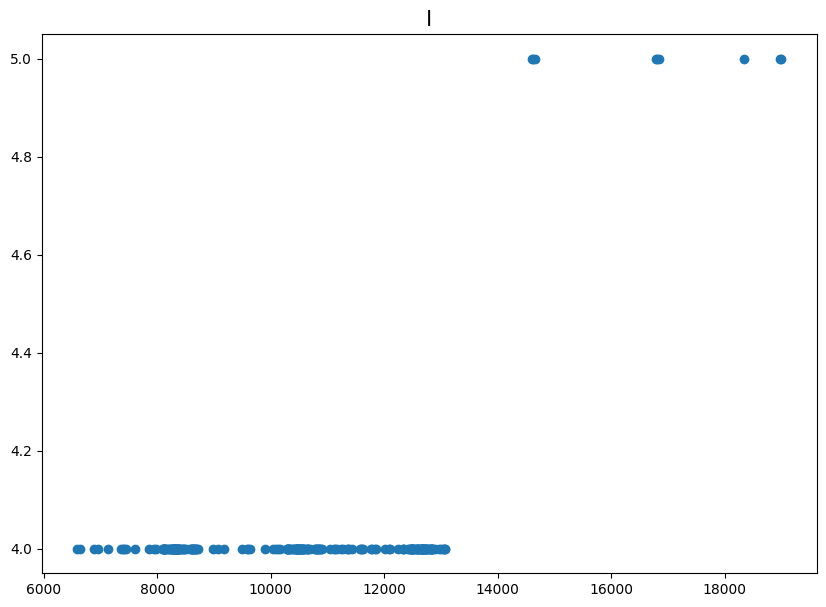

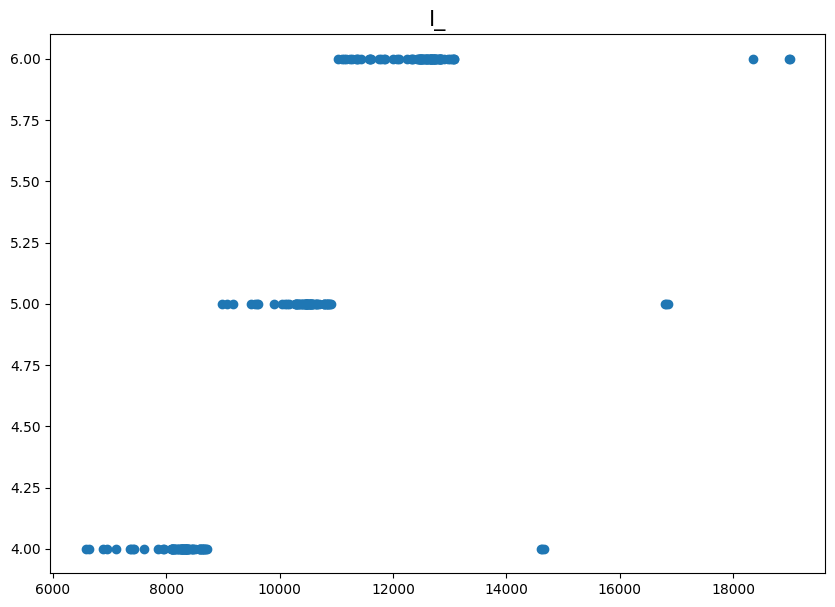

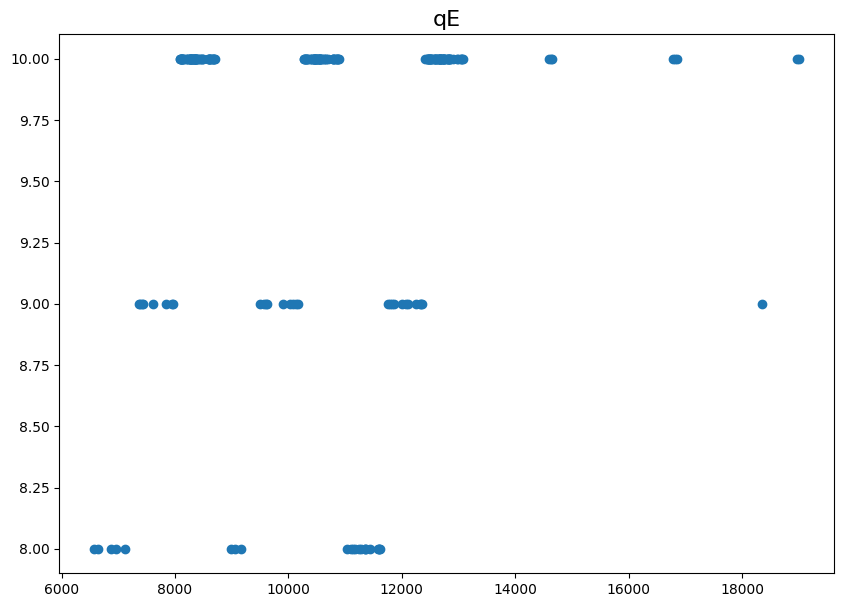

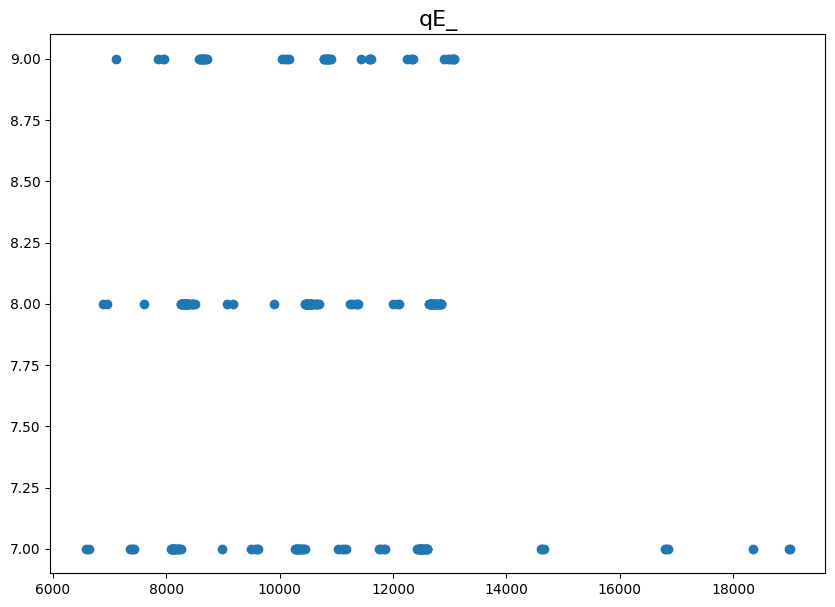

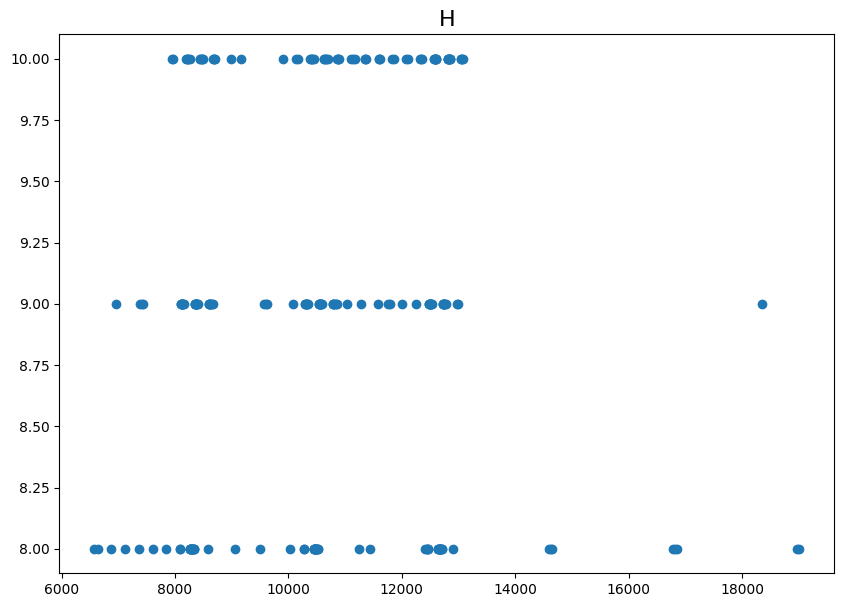

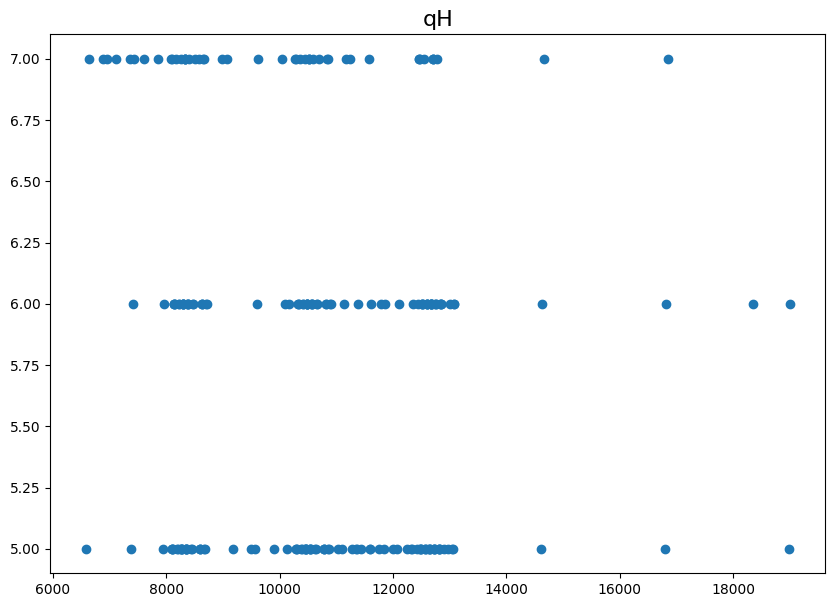

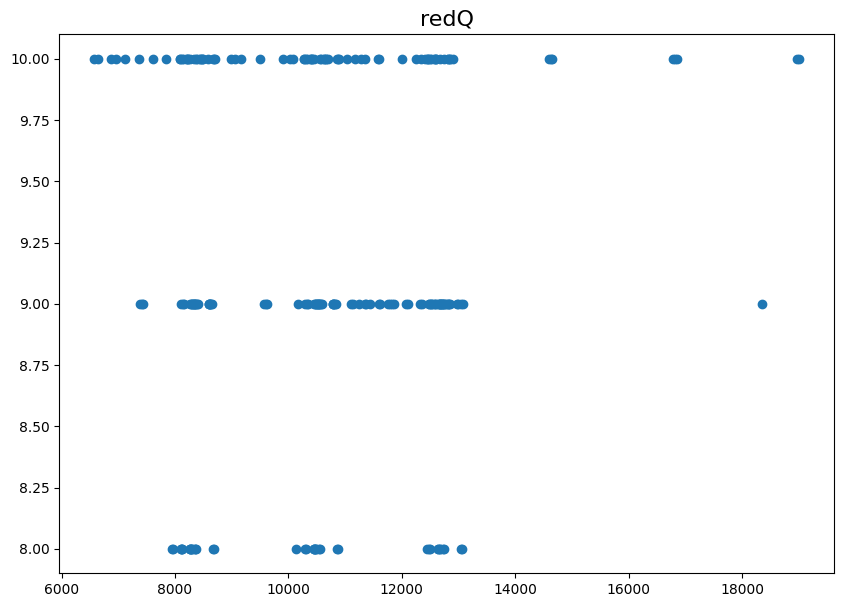

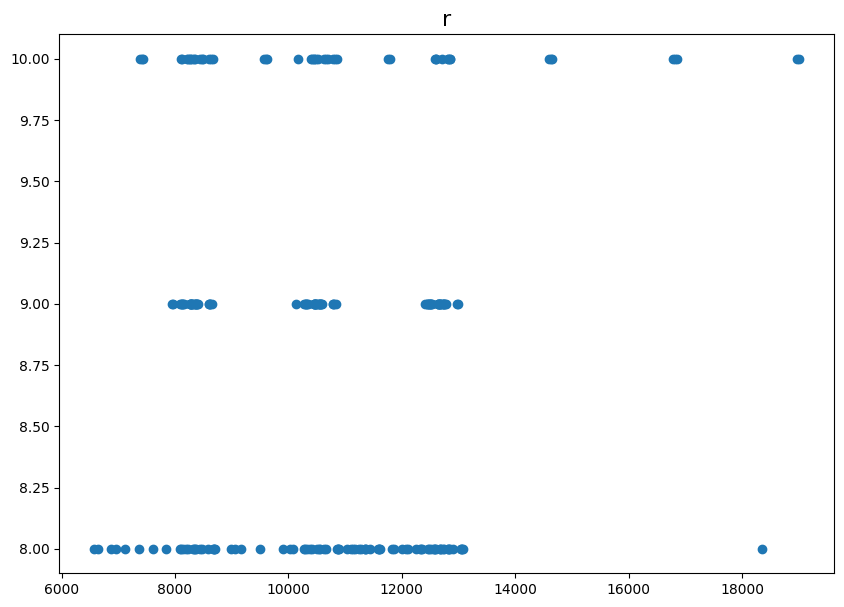

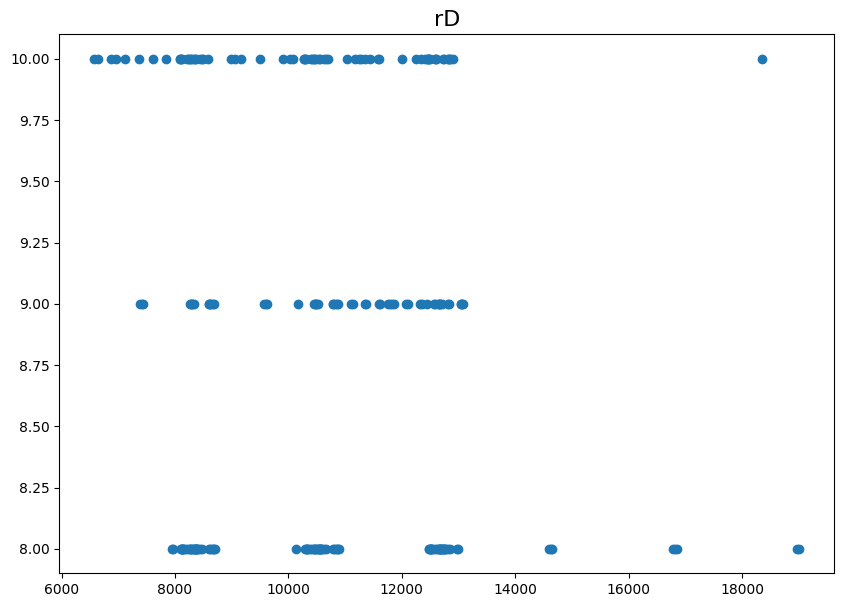

In [15]:
num=1
for key in ks:
    fig,ax = plt.subplots()
    ax.scatter(errors[key].index,np.log10(errors[key]))
    ax.set_title(key)